# ***Multivariate LSTM for Stock Price Forecasting***

**Created by Saifur Rahman, 2024.**

## **0. Required libraries.**

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

## **1. Data Pre-processing**



### I. Load data into dataframes and clean them.


In [ ]:
# List of stock symbols
stockList = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT']

# Define the start date and end date for the data
start_date = "2014-01-01"
end_date = "2023-12-31"

# Define the features to be used for scaling
features = ['Close', 'Volume', 'Open', 'High', 'Low']

# Dictionary to hold DataFrames for each stock
df_dict = {}

# Load and process data for each company
for stock in stockList:
    # Download the data and filter required columns
    data = yf.download(stock, start=start_date, end=end_date)[features]

    # Reset the index, convert 'Date' column to datetime, and clean column names
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date']).dt.date

    # Round the relevant columns to 3 decimal places
    data[['Close', 'Open', 'High', 'Low']] = data[['Close', 'Open', 'High', 'Low']].round(3)

    # Check if columns have a MultiIndex and flatten if necessary
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [' '.join(col).strip() for col in data.columns.values]

    # Clean the column names
    data.columns = data.columns.str.replace(f' {stock}', '', regex=False)

    # Store the cleaned DataFrame in the dictionary
    df_dict[stock] = data

### II. Split data into train and test sets and visualize them.

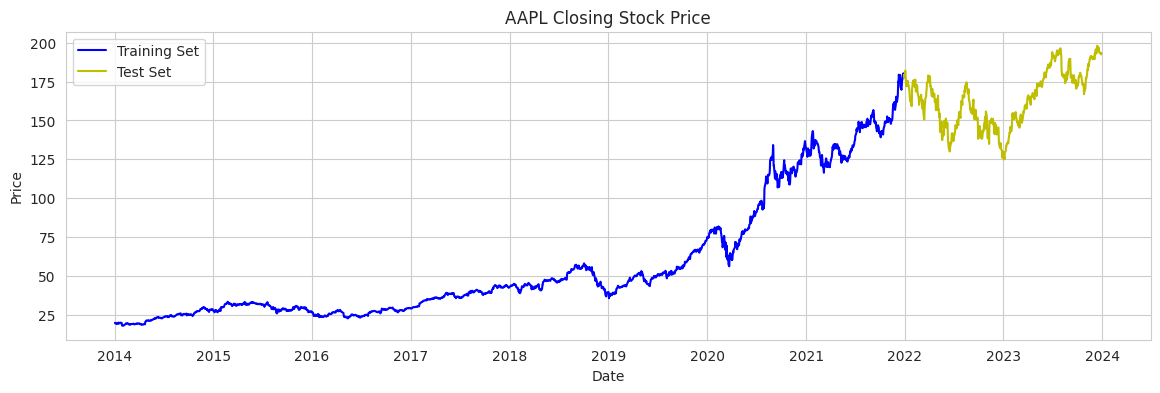

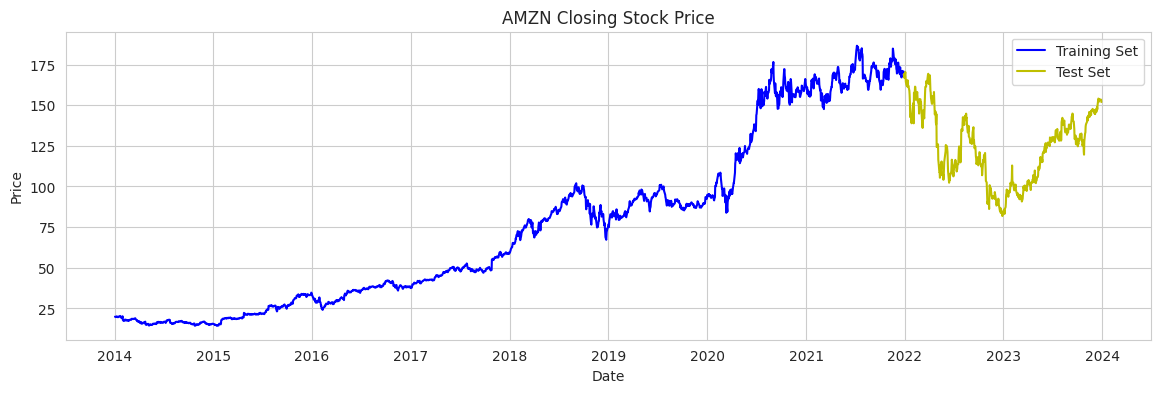

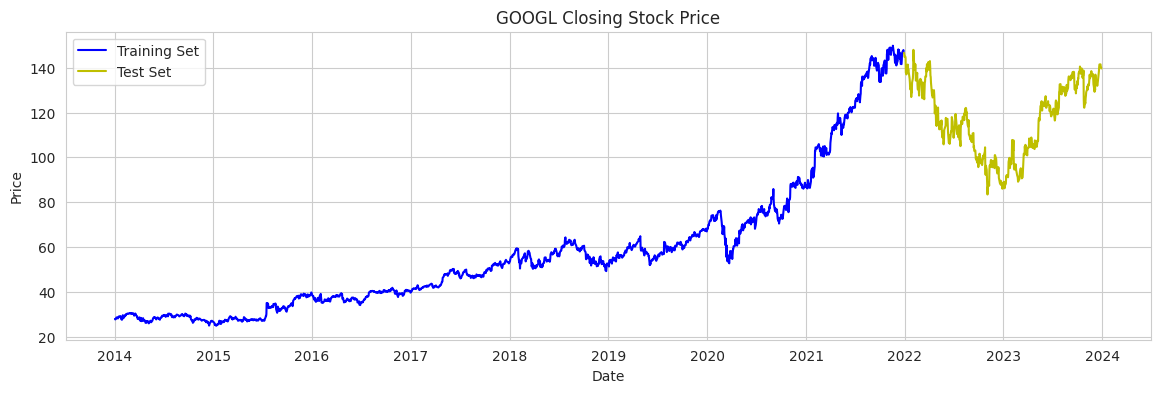

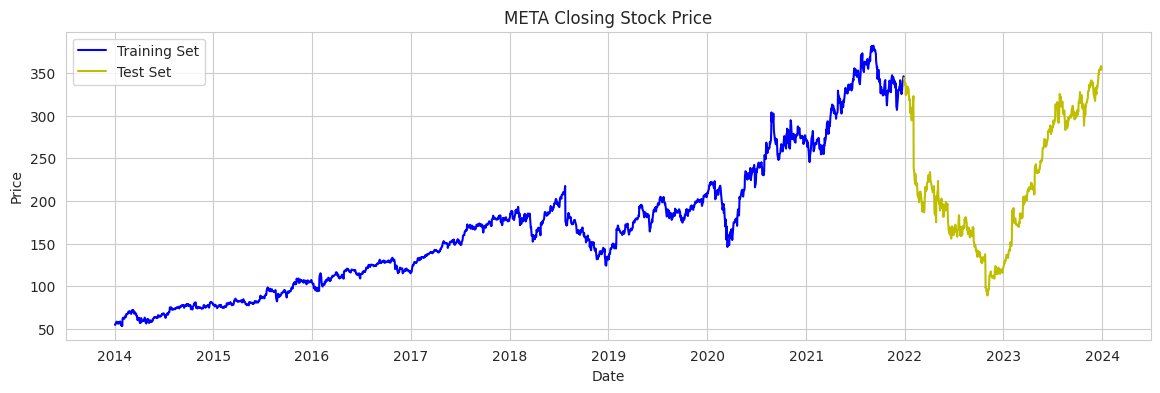

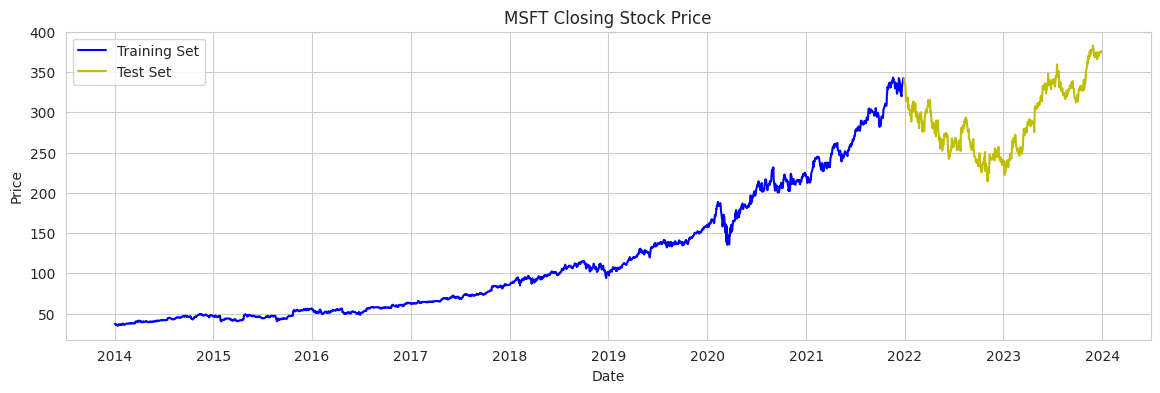

In [3]:
# Split data for each company into training and testing sets
train_data = {}
test_data = {}
for stock in stockList:
    data = df_dict[stock]
    train, test = train_test_split(data, test_size=0.2, shuffle=False)
    train_data[stock] = train
    test_data[stock] = test

# Plot stock data for each companies
for stock in stockList:
    plt.figure(figsize=(14, 4))
    plt.plot(train_data[stock]['Date'], train_data[stock]['Close'], label='Training Set', linestyle='-', color='b')
    plt.plot(test_data[stock]['Date'], test_data[stock]['Close'], label='Test Set', linestyle='-', color='y')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.legend()
    plt.title(stock + ' Closing Stock Price')
    plt.show()

### III. Scale features using MinMaxScaler

In [4]:
# Data transformation using MinMaxScaler
transform_train = {}
transform_test = {}
scaler = {}

for stock in stockList:
    if all(feature in train_data[stock] for feature in features):
        sc = MinMaxScaler(feature_range=(0, 1))
        train_data_scaled = sc.fit_transform(train_data[stock][features])
        test_data_scaled = sc.transform(test_data[stock][features])
        transform_train[stock] = train_data_scaled
        transform_test[stock] = test_data_scaled
        scaler[stock] = sc
    else:
        print(f"Missing features for {stock}: {', '.join(set(features) - set(train_data[stock].columns))}")

### IV. Create train and test sets using scaled data.

In [5]:
# Create train and test sets for LSTM model
trainset = {}
testset = {}
for stock in stockList:
    if stock in transform_train and stock in transform_test:
        trainset[stock] = {}
        X_train = []
        y_train = []
        for i in range(30, transform_train[stock].shape[0]):
            X_train.append(transform_train[stock][i-30:i, :])
            y_train.append(transform_train[stock][i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[stock]["X"] = X_train
        trainset[stock]["y"] = y_train

        testset[stock] = {}
        X_test = []
        y_test = []
        for i in range(30, transform_test[stock].shape[0]):
            X_test.append(transform_test[stock][i-30:i, :])
            y_test.append(transform_test[stock][i, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[stock]["X"] = X_test
        testset[stock]["y"] = y_test

### V. Print shapes of train and test data.

In [ ]:
# Create a DataFrame to store the shapes of train and test sets
arr_buff = []
for stock in stockList:
    if stock in trainset and stock in testset:
        buff = {}
        buff["X_train"] = trainset[stock]["X"].shape
        buff["y_train"] = trainset[stock]["y"].shape
        buff["X_test"] = testset[stock]["X"].shape
        buff["y_test"] = testset[stock]["y"].shape
        arr_buff.append(buff)

df_shapes = pd.DataFrame(arr_buff, index=stockList)
print(df_shapes)

## **2. LSTM Model**


### Create and train LSTM model.

In [ ]:
# Create an LSTM model
def create_lstm_model(input_shape):
    regressor = Sequential()
    regressor.add(Input(shape=input_shape))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))
    regressor.add(Dense(units=1))
    return regressor

# Fitting the LSTM model to the training data
models = {}
for stock in stockList:
    if stock in trainset and stock in testset:
        model = create_lstm_model((trainset[stock]["X"].shape[1], trainset[stock]["X"].shape[2]))
        model.compile(optimizer='rmsprop', loss='mean_squared_error')
        print(f"Fitting to {stock}")
        model.fit(trainset[stock]["X"], trainset[stock]["y"], epochs=50, batch_size=16)
        models[stock] = model

Fitting to AAPL
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0205
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0035
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0047
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028
Epoch 12/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028
Epoch 13/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029
Epoch 14/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032
Epoch 15/50
124/124 ━━━━━━━━━━━━━━━━━

## **3. Predictions**


### Make and visualize predictions.

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


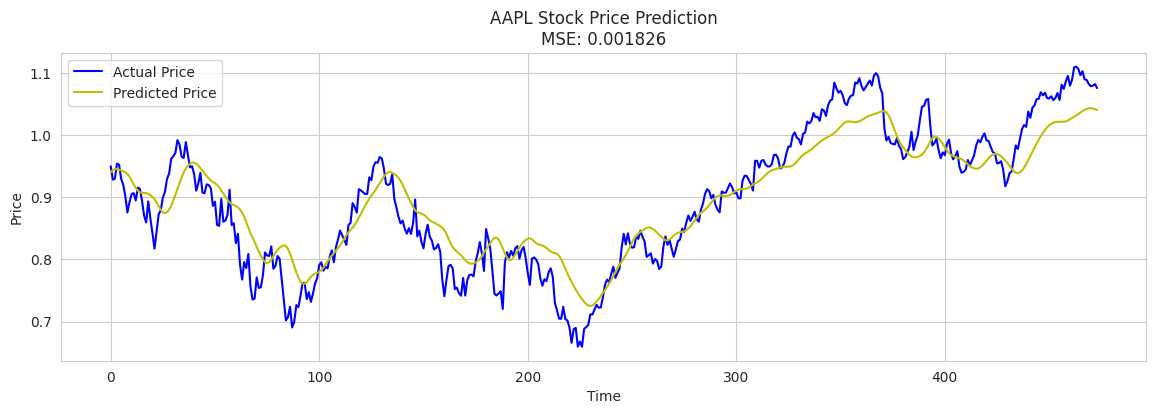

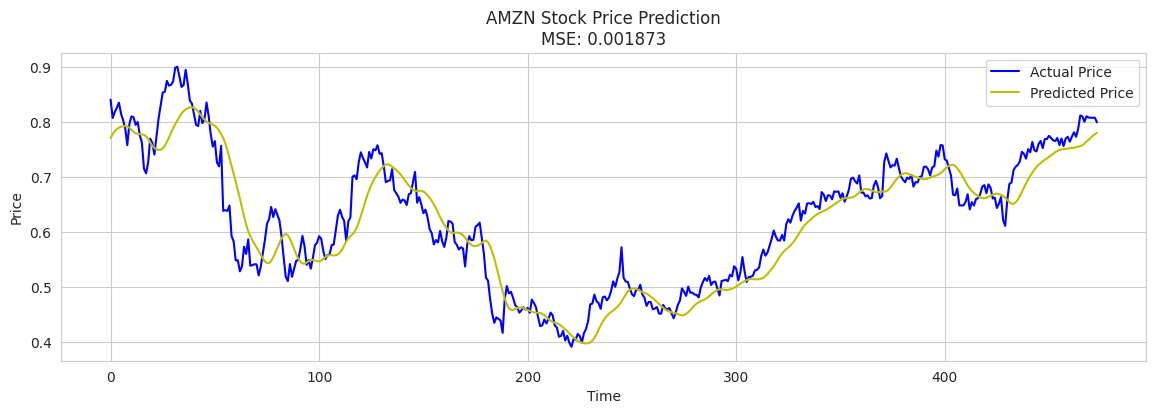

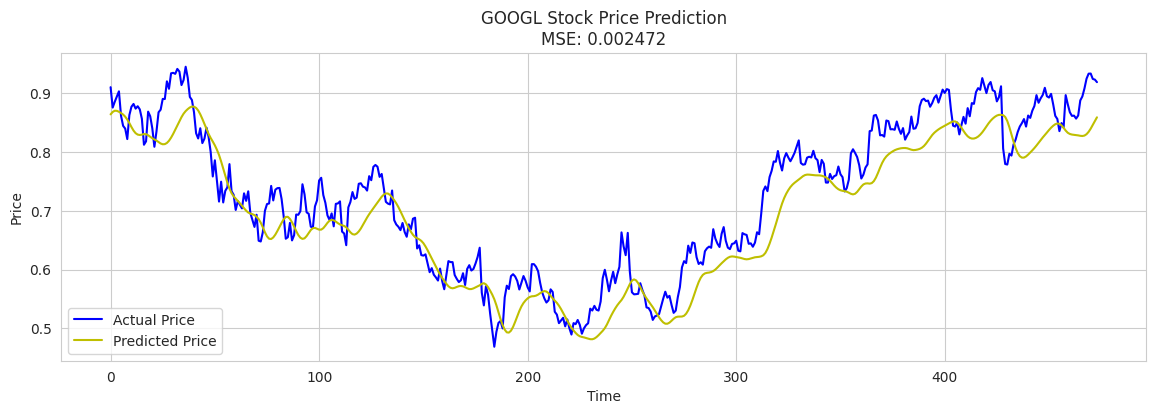

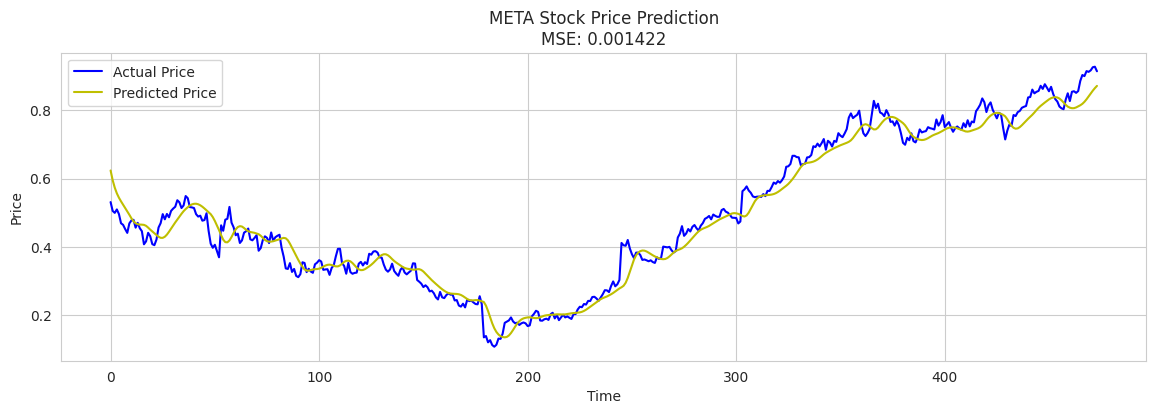

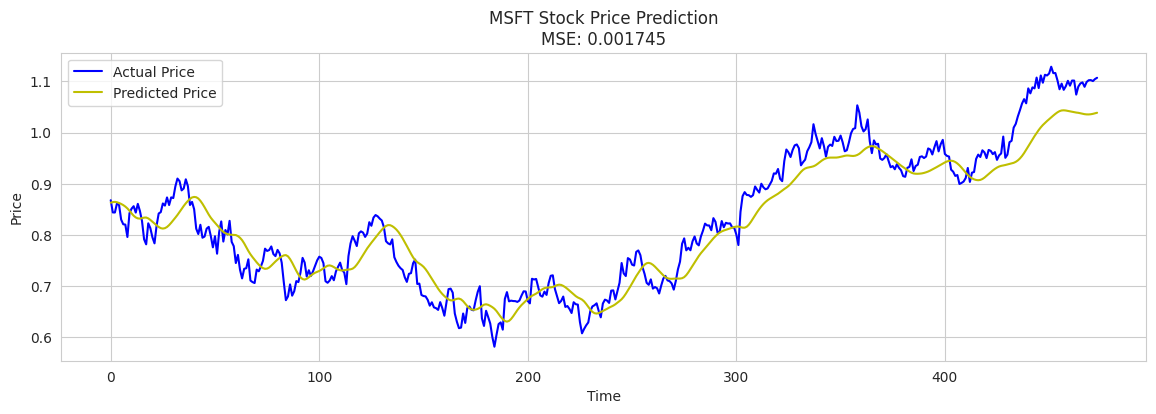

In [ ]:
# Make predictions using the trained LSTM models
predictions = {}
for stock in stockList:
    if stock in models and stock in testset:
        model = models[stock]
        X_test = testset[stock]["X"]
        y_test = testset[stock]["y"]
        y_pred = model.predict(X_test)
        predictions[stock] = {"y_test": y_test, "y_pred": y_pred}

# Plot the predictions
for stock in stockList:
    if stock in predictions:
        y_test = predictions[stock]["y_test"]
        y_pred = predictions[stock]["y_pred"]
        mse = mean_squared_error(y_test, y_pred)
        plt.figure(figsize=(14, 4))
        plt.plot(y_test, label='Actual Price', color='b')
        plt.plot(y_pred, label='Predicted Price', color='y')
        plt.ylabel('Price')
        plt.xlabel('Time')
        plt.legend()
        plt.title(f'{stock} Stock Price Prediction\nMSE: {mse:.6f}')
        plt.show()